In [30]:
import astropy.coordinates as coord
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
allstar_filename = 'allStarLite-dr17-synspec_rev1.fits'
allstar = at.Table.read(allstar_filename)

In [36]:
idx = np.isfinite(allstar['RA'])
allstar_c = coord.SkyCoord(allstar['RA'][idx]*u.deg, 
                           allstar['DEC'][idx]*u.deg)

# Kepler

In [37]:
kic = at.Table.read('../Kepler-K2/kepler_kic.fits')
kic_c = coord.SkyCoord(kic['kic_ra']*u.hourangle, 
                       kic['kic_dec']*u.deg)

In [38]:
with_2mass_mask = kic['kic_2mass_id'] != 'nan'
kic_with_2mass = kic[with_2mass_mask]
kic_with_2mass['APOGEE_ID'] = [f'2M{x}' for x in kic_with_2mass['kic_2mass_id']]

kic_without_2mass = kic[~with_2mass_mask]
len(kic_with_2mass), len(kic_without_2mass)

(6149303, 7011726)

In [39]:
kic_apogee_with_2mass = at.join(
    kic_with_2mass, 
    allstar['APOGEE_ID', 'RA', 'DEC'], 
    keys='APOGEE_ID'
)
len(kic_apogee_with_2mass)

28930

In [50]:
kic_apogee_with_2mass_allcols = at.join(
    kic_with_2mass, 
    allstar, 
    keys='APOGEE_ID'
)

In [84]:
kic_apogee_with_2mass_allcols.write(
    f'../Kepler-K2/kepler_kic_{allstar_filename.split(".")[0]}.fits', 
    overwrite=True
)

In [56]:
mdwarfs = kic_apogee_with_2mass_allcols[
    (kic_apogee_with_2mass_allcols['TEFF'] < 3800) &
    (kic_apogee_with_2mass_allcols['LOGG'] > 4)
]
len(mdwarfs)

182

In [85]:
mdwarfs['TEFF'].min()

3164.1838

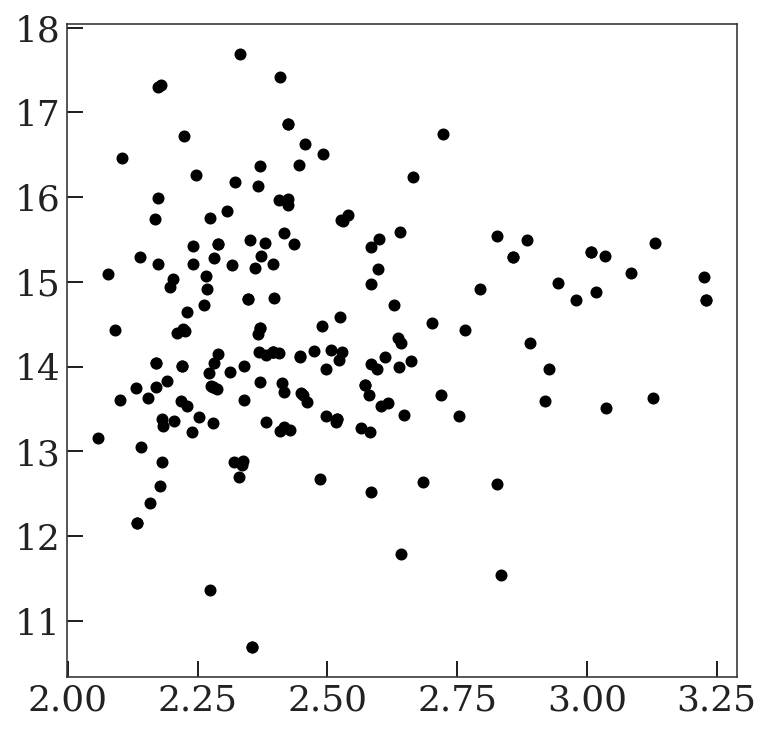

In [91]:
plt.scatter(
    mdwarfs['GAIAEDR3_PHOT_BP_MEAN_MAG'] - mdwarfs['GAIAEDR3_PHOT_RP_MEAN_MAG'],
    mdwarfs['GAIAEDR3_PHOT_G_MEAN_MAG'] #- coord.Distance(parallax=mdwarfs['GAIAEDR3_PARALLAX']*u.mas).distmod.value,
)

/cm/shared/sw/nix/store/gj29ixlv3w00nx3hbi0lm1s2cz9hi3vp-python-3.9.7-view/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


(-0.2, 0.2)

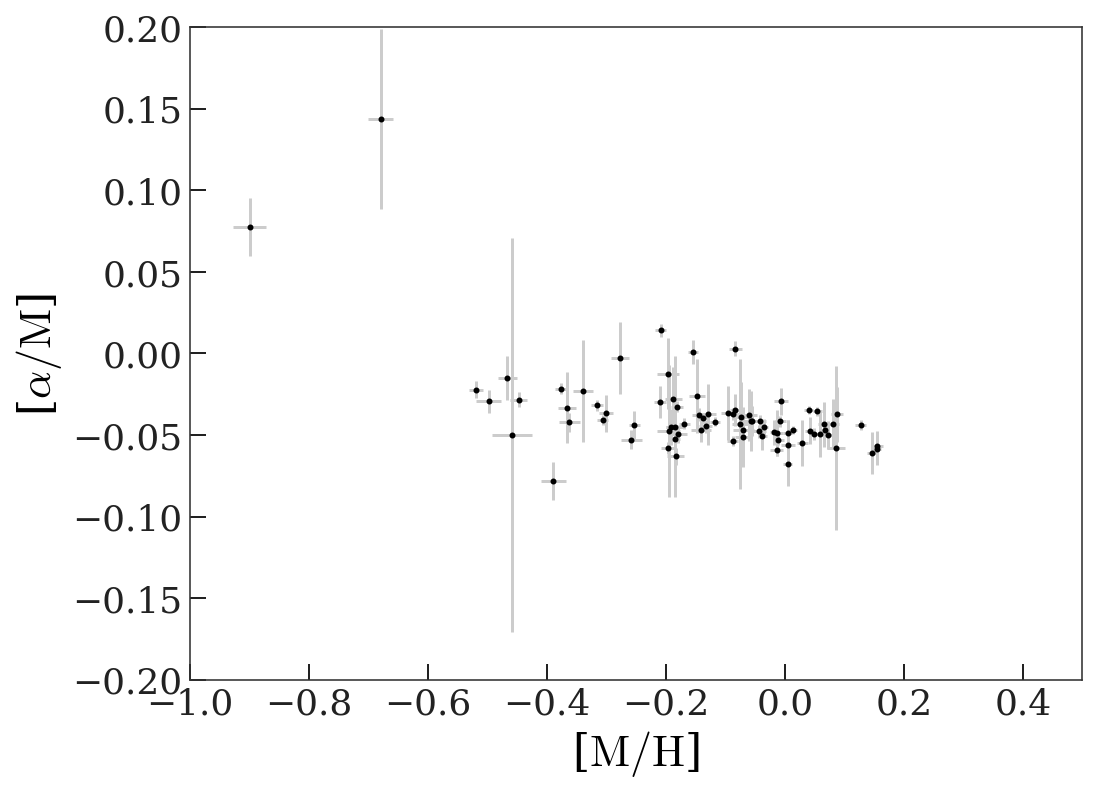

In [76]:
plt.figure(figsize=(8, 6))
plt.errorbar(mdwarfs['M_H'], 
             mdwarfs['ALPHA_M'],
             xerr=mdwarfs['M_H_ERR'], 
             yerr=mdwarfs['ALPHA_M_ERR'],
             ls='none', marker='o', ecolor='#cccccc', ms=3)

plt.xlabel(r'[${\rm M}/{\rm H}$]')
plt.ylabel(r'[$\alpha/{\rm M}$]')
plt.xlim(-1, 0.5)
plt.ylim(-0.2, 0.2)

Positional cross-match for non-2MASS sources:

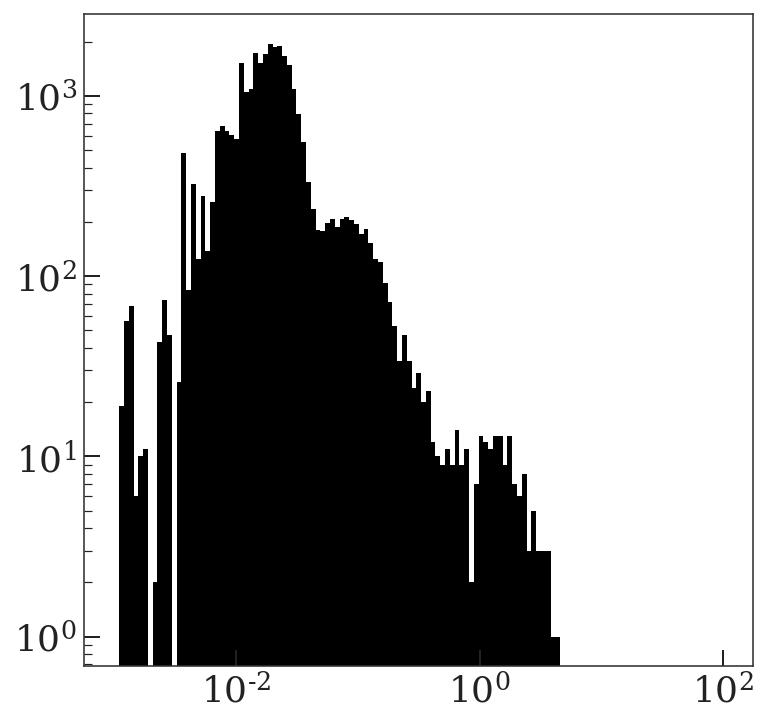

In [40]:
c1 = coord.SkyCoord(
    kic_apogee_with_2mass['RA']*u.deg, 
    kic_apogee_with_2mass['DEC']*u.deg,
)
c2 = coord.SkyCoord(
    kic_apogee_with_2mass['kic_ra']*u.hourangle, 
    kic_apogee_with_2mass['kic_dec']*u.deg,
)
sep = c1.separation(c2)

plt.hist(sep.to_value(u.arcsec), bins=np.logspace(-3, 2, 128));
plt.xscale('log')
plt.yscale('log')

array([4601.92650953, 4636.83726827, 4616.48006075, ..., 1440.39211087,
       1286.09027627, 1285.14824973])

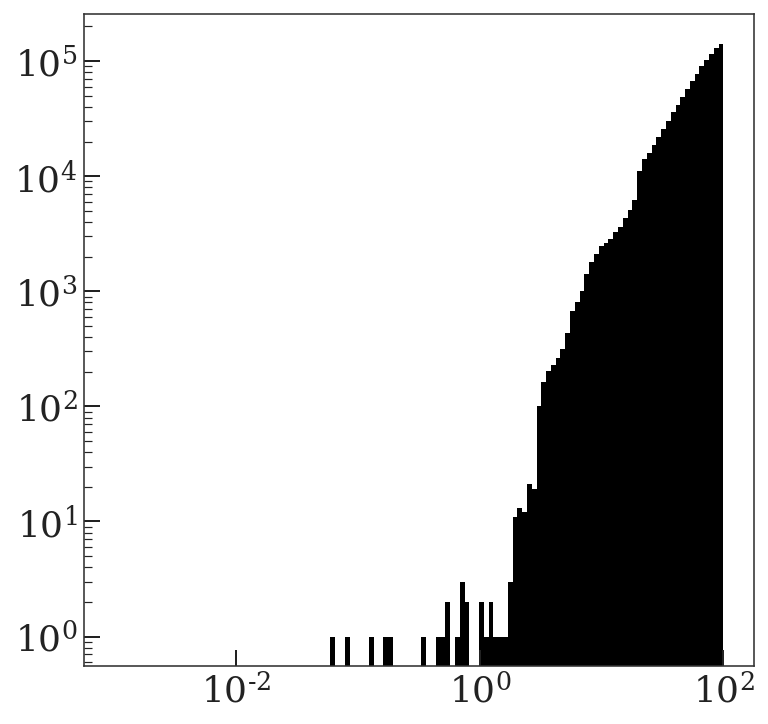

In [48]:
c2 = coord.SkyCoord(
    kic_without_2mass['kic_ra']*u.hourangle, 
    kic_without_2mass['kic_dec']*u.deg,
)
idx, sep, _ = c2.match_to_catalog_sky(allstar_c)

plt.hist(sep.to_value(u.arcsec), bins=np.logspace(-3, 2, 128));
plt.xscale('log')
plt.yscale('log')

In [47]:
sep_mask = (sep < 4*u.arcsec)
sep_mask.sum()

677